# Eye Disease Classification using Deep Learning

This project aims to develop a deep learning model using Convolutional Neural Networks (CNN) to classify retinal images into four categories: Normal, Diabetic Retinopathy, Cataract, and Glaucoma. The dataset comprises approximately 1000 retinal images for each class, collected from various sources, including IDRiD, Ocular recognition, and HRF. The goal is to leverage CNN’s powerful feature extraction capabilities to accurately diagnose these eye conditions based on retinal images. This model could assist in early detection and treatment planning for patients, potentially improving outcomes for those with retinal diseases.

## Importing Packages

In [5]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

# preprocessing
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, recall_score, precision_score

# models
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

import os

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

## Reading in Data

In [22]:
import os
from PIL import Image
import numpy as np

# path to the unzipped dataset
dataset_path = (r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset')

# Define the classes
classes = ['normal', 'diabetic_retinopathy', 'cataract', 'glaucoma']

# Initialize an empty list to store the images and labels
images = []
labels = []

# Loop through each class folder and load the images
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):  
            image_path = os.path.join(class_folder, file_name)
            image = Image.open(image_path)
            image = image.resize((224, 224))  # Resize to a consistent size if needed
            image_array = np.array(image)
            images.append(image_array)
            labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with labels")


Loaded 4310 images with labels


## Preliminary Analysis

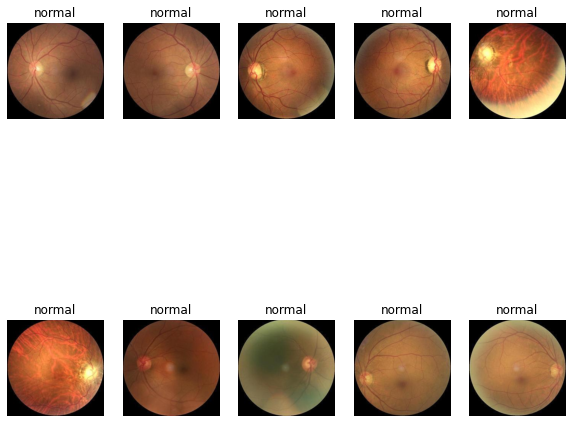

In [23]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10

# Select the first 'num_images' from the dataset
subset_images = images[:num_images]
subset_labels = labels[:num_images]

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # 2 rows and 5 columns
    plt.imshow(subset_images[i])
    plt.title(classes[subset_labels[i]])
    plt.axis('off')  # Hide the axes

plt.show()

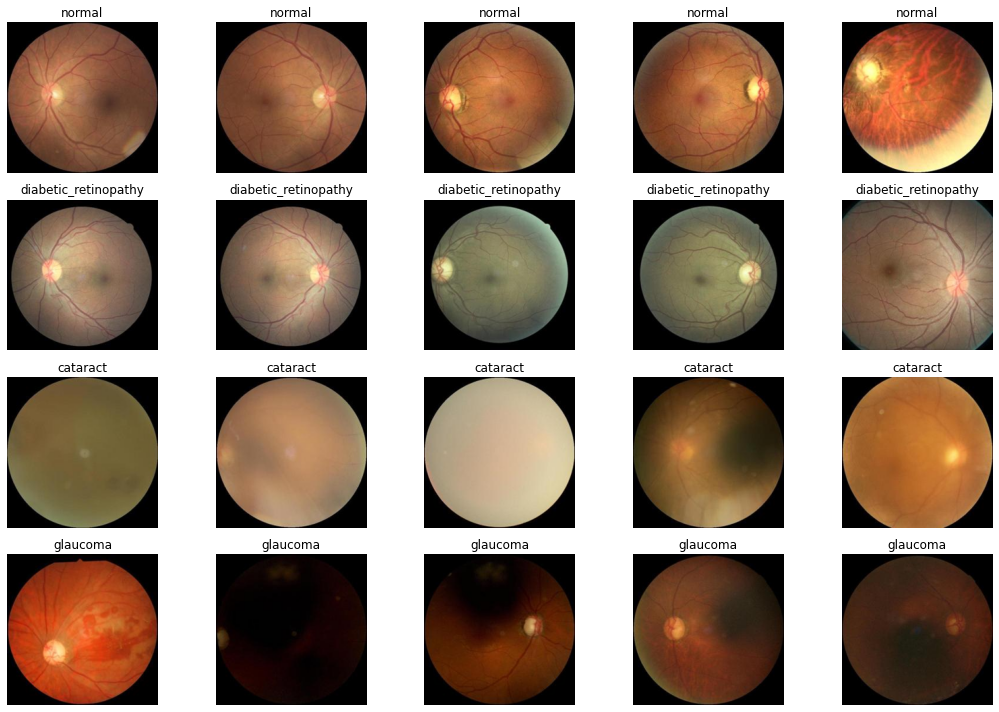

In [8]:
# Number of images to display per class
num_images_per_class = 5

# empty lists to store selected images and labels
selected_images = []
selected_labels = []

# Loop through each class and select a subset of images
for class_label in range(len(classes)):  
    class_indices = [i for i, label in enumerate(labels) if label == class_label]
    class_images = images[class_indices][:num_images_per_class]  
    selected_images.extend(class_images)
    selected_labels.extend([class_label] * num_images_per_class)

# Plot images
plt.figure(figsize=(15, 10))
for i in range(len(selected_images)):
    plt.subplot(len(classes), num_images_per_class, i + 1)  # Rows by classes, columns by number of images per class
    plt.imshow(selected_images[i])
    plt.title(classes[selected_labels[i]])
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [9]:
# how many images were loaded per class
for class_label in range(len(classes)):
    class_count = sum([1 for label in labels if label == class_label])
    print(f"{classes[class_label]}: {class_count} images")


normal: 1074 images
diabetic_retinopathy: 1098 images
cataract: 1038 images
glaucoma: 1007 images


In [10]:
# empty list to store image paths
image_paths = []

# Loop through each class and get the paths of all images
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):  
            image_path = os.path.join(class_folder, file_name)
            image_paths.append(image_path)

print(image_paths[:10])

['C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1034_left.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1034_right.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1060_left.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1060_right.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1253_left.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\1253_right.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\2329_left.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\2329_right.jpg', 'C:\\Users\\Sara\\Desktop\\Personal Projects\\Eye Disease Classification\\dataset\\normal\\2331_left.jpg', 'C:\\Users\\Sara\\Desktop\\Perso

In [11]:
# image sizes
image_sizes = []
for image_path in image_paths:  
    with Image.open(image_path) as img:
        image_sizes.append(img.size)

print(pd.Series(image_sizes).value_counts())

(256, 256)    4217
Name: count, dtype: int64


In [12]:
# image quality check
import cv2

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blurriness_scores = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurriness_scores.append(variance_of_laplacian(gray))

print(pd.Series(blurriness_scores).describe())  # Summary of blurriness scores


count    4217.000000
mean      156.644054
std       140.739869
min         2.768325
25%        59.111004
50%       113.896173
75%       206.818091
max       966.930134
dtype: float64


In [13]:
# class distribution
from collections import Counter

class_distribution = Counter(labels)  
print(class_distribution)


Counter({1: 1098, 0: 1074, 2: 1038, 3: 1007})


In [14]:
# to find duplicate images

import cv2
import hashlib

def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    diff = gray[:, 1:] > gray[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

hashes = {}
duplicates = []

for image_path in image_paths:
    image = cv2.imread(image_path)
    h = dhash(image)
    if h in hashes:
        # Store duplicates in the list
        duplicates.append((image_path, hashes[h]))
    else:
        hashes[h] = image_path

# Print or handle the duplicate images
for img1, img2 in duplicates:
    print(f"Duplicate found: {img1} and {img2}")

# Extract the list of duplicate image paths
duplicate_image_paths = [img1 for img1, _ in duplicates]

print("List of duplicate image paths:")
print(duplicate_image_paths)



Duplicate found: C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\normal\2869_left.jpg and C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\normal\2655_left.jpg
Duplicate found: C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy\11573_right.jpeg and C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy\10675_right.jpeg
Duplicate found: C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy\1272_left.jpeg and C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy\10947_left.jpeg
Duplicate found: C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\cataract\2104_left.jpg and C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\normal\2335_right.jpg
Duplicate found: C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classificat

In [15]:
# color space analysis

for image_path in image_paths:
    with Image.open(image_path) as img:
        rgb_img = img.convert('RGB')  # Convert to RGB if necessary
        rgb_img.save(image_path)  # Save the image


## Data Wrangling

Make image sizes consistent

In [24]:
# target size
target_size = (256, 256)  

# Resize images
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):  
            image_path = os.path.join(class_folder, file_name)
            with Image.open(image_path) as img:
                img = img.resize(target_size)  # Resize the image
                img.save(image_path)  # Save the resized image

remove images with low quality

In [17]:
def calculate_sharpness(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute the Laplacian of the image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    # Calculate the variance of the Laplacian
    sharpness = laplacian.var()
    return sharpness

In [18]:
threshold = 66.32  
low_quality_images = [image_path for image_path in image_paths if calculate_sharpness(image_path) < threshold]
print(f"Number of low-quality images: {len(low_quality_images)}")


Number of low-quality images: 1198


replace duplicate images with augmented versions

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_overwrite_image(image_path, num_augmented_images=1):
    """
    Augment a single image and overwrite the original image with the augmented version.
    
    Parameters:
    - image_path: Path to the input image.
    - num_augmented_images: Number of augmented images to generate (default is 1, since you want to overwrite).
    """
    # Load the image
    image = load_img(image_path)
    image_array = img_to_array(image)
    image_array = image_array.reshape((1,) + image_array.shape)
    
    # Generate and overwrite the image with the augmented version
    for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
        if i >= num_augmented_images:
            break
        augmented_image = batch[0].astype('uint8')
        save_img(image_path, augmented_image)  # Save directly over the original file

# Apply augmentation to all duplicate images
for image_path in duplicate_image_paths:
    augment_and_overwrite_image(image_path)

print("Augmentation complete. Duplicate images have been augmented and overwritten.")


Augmentation complete. Duplicate images have been augmented and overwritten.


data augmentation - to create more images

In [21]:
# 93 images for glaucoma

import albumentations as A
from PIL import Image
import numpy as np
import os

# augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(width=256, height=256, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
])

# Load an image
image_path = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\glaucoma\_4_5317326.jpg'
image = np.array(Image.open(image_path))

# Folder to save augmented images
save_dir = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\glaucoma'

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Generate and save augmented images
num_images_to_generate = 93
for i in range(num_images_to_generate):
    augmented_image = transform(image=image)['image']
    augmented_image_pil = Image.fromarray(augmented_image)
    
    # Save in the glaucoma folder with a new filename
    augmented_image_pil.save(os.path.join(save_dir, f'augmented_glaucoma_{i}.jpg'))



In [26]:
# 62 images for cataract

# Load an image
image_path = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\cataract\_14_7805520.jpg'
image = np.array(Image.open(image_path))

# Folder to save augmented images
save_dir = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\cataract'

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Generate and save augmented images
num_images_to_generate = 62
for i in range(num_images_to_generate):
    augmented_image = transform(image=image)['image']
    augmented_image_pil = Image.fromarray(augmented_image)
    
    # Save in the cataract folder with a new filename
    augmented_image_pil.save(os.path.join(save_dir, f'augmented_cataract_{i}.jpg'))



In [27]:
# 2 images for diabetic_retinopathy

# Load an image
image_path = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy\1021_right.jpeg'
image = np.array(Image.open(image_path))

# Folder to save augmented images
save_dir = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\diabetic_retinopathy'

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Generate and save augmented images
num_images_to_generate = 2
for i in range(num_images_to_generate):
    augmented_image = transform(image=image)['image']
    augmented_image_pil = Image.fromarray(augmented_image)
    
    # Save in the diabetic_retinopathy folder with a new filename
    augmented_image_pil.save(os.path.join(save_dir, f'augmented_diabetic_retinopathy_{i}.jpg'))



In [29]:
# 26 images for normal

# Load an image
image_path = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\normal\1253_left.jpg'
image = np.array(Image.open(image_path))

# Folder to save augmented images
save_dir = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset\normal'

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Generate and save augmented images
num_images_to_generate = 26
for i in range(num_images_to_generate):
    augmented_image = transform(image=image)['image']
    augmented_image_pil = Image.fromarray(augmented_image)
    
    # Save in the normal folder with a new filename
    augmented_image_pil.save(os.path.join(save_dir, f'augmented_normal_{i}.jpg'))



In [32]:
# how many images were loaded per class
for class_label in range(len(classes)):
    class_count = sum([1 for label in labels if label == class_label])
    print(f"{classes[class_label]}: {class_count} images")

normal: 1074 images
diabetic_retinopathy: 1098 images
cataract: 1038 images
glaucoma: 1100 images


In [33]:
import os

# Path to your dataset directory
dataset_dir = r'C:\Users\Sara\Desktop\Personal Projects\Eye Disease Classification\dataset'

# List the subdirectories (classes)
classes = ['normal', 'diabetic_retinopathy', 'cataract', 'glaucoma']

# Loop over each class directory and count the number of images
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    image_count = len([img for img in os.listdir(class_dir) if img.endswith(('jpg', 'jpeg', 'png'))])
    print(f"{class_name}: {image_count} images")


normal: 1100 images
diabetic_retinopathy: 1100 images
cataract: 1100 images
glaucoma: 1100 images


## Exploratory Data Analysis

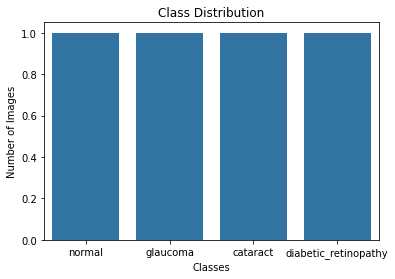

In [34]:
import seaborn as sns

image_labels = ['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']  

# to count occurrences of each label
class_counts = Counter(image_labels)

# Plotting class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

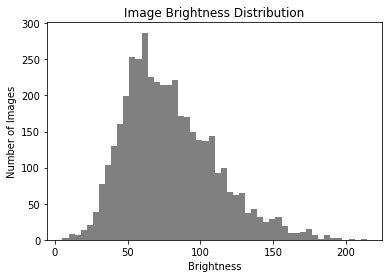

In [34]:
brightness = []
for image_path in image_paths:
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness.append(np.mean(gray_img))

# Visualize brightness
plt.hist(brightness, bins=50, color='gray')
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Number of Images")
plt.show()

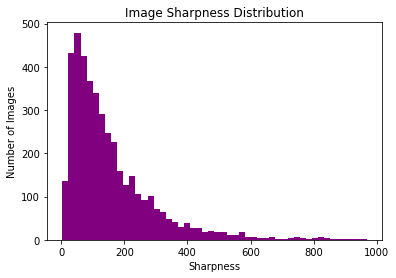

In [36]:
def calculate_sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

sharpness_values = []
for image_path in image_paths:
    img = cv2.imread(image_path)
    sharpness = calculate_sharpness(img)
    sharpness_values.append(sharpness)

# Visualize sharpness
plt.hist(sharpness_values, bins=50, color='purple')
plt.title("Image Sharpness Distribution")
plt.xlabel("Sharpness")
plt.ylabel("Number of Images")
plt.show()

In [37]:
corrupted_images = []
for image_path in image_paths:
    try:
        img = Image.open(image_path)
        img.verify()  # Check if the image is corrupted
    except (IOError, SyntaxError) as e:
        corrupted_images.append(image_path)

print(f"Found {len(corrupted_images)} corrupted images.")

Found 0 corrupted images.


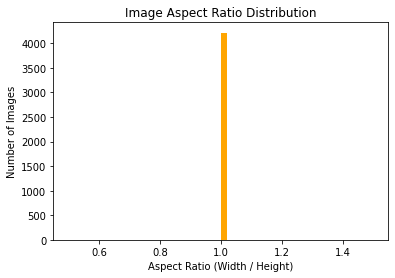

In [38]:
aspect_ratios = []
for image_path in image_paths:
    img = Image.open(image_path)
    width, height = img.size
    aspect_ratios.append(width / height)

# Visualize aspect ratios
plt.hist(aspect_ratios, bins=50, color='orange')
plt.title("Image Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Number of Images")
plt.show()

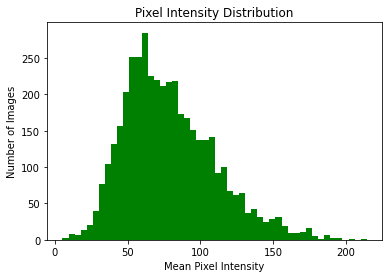

In [35]:
pixel_intensity = []
for image_path in image_paths:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Use cv2.IMREAD_COLOR for RGB
    pixel_intensity.append(np.mean(img))

plt.hist(pixel_intensity, bins=50, color='green')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()

## Machine Learning - Deep Learning

Splitting Data and Standardizing Images

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (256, 256)  # Resize images to 256x256 pixels

# instance of ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    validation_split=0.2  # Use 20% of the data for validation/testing
)

# training and testing data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,  
    target_size=image_size,  # Resize images to 256x256
    batch_size=32,  # Number of images to process in a batch
    class_mode='sparse',  
    subset='training'  # training data
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset='validation'  # validation/testing data
)

# Check the number of images in the generators
print(f"Training images: {train_generator.samples}")
print(f"Validation images: {validation_generator.samples}")



Found 3520 images belonging to 4 classes.
Found 880 images belonging to 4 classes.
Training images: 3520
Validation images: 880


CNN Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to feed into fully connected layers
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer (4 classes, use softmax for multi-class classification)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [38]:
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])


In [39]:
# Inspect the first batch of data from the train generator
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")  
print(f"y_batch shape: {y_batch.shape}")  


x_batch shape: (32, 256, 256, 3)
y_batch shape: (32,)


In [40]:
# Inspect the first batch of data from the validation generator
x_val_batch, y_val_batch = next(validation_generator)
print(f"x_val_batch shape: {x_val_batch.shape}")  
print(f"y_val_batch shape: {y_val_batch.shape}")

x_val_batch shape: (32, 256, 256, 3)
y_val_batch shape: (32,)


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                                patience=10, 
                                restore_best_weights=True)


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

model.summary()

Epoch 1/50
110/110 [==============================] - 204s 2s/step - loss: 0.5500 - accuracy: 0.7719 - val_loss: 0.7643 - val_accuracy: 0.6284
Epoch 2/50
110/110 [==============================] - 167s 2s/step - loss: 0.5178 - accuracy: 0.7756 - val_loss: 0.8275 - val_accuracy: 0.6068
Epoch 3/50
110/110 [==============================] - 166s 2s/step - loss: 0.4540 - accuracy: 0.8179 - val_loss: 0.7851 - val_accuracy: 0.6295
Epoch 4/50
110/110 [==============================] - 172s 2s/step - loss: 0.4213 - accuracy: 0.8284 - val_loss: 0.9021 - val_accuracy: 0.5841
Epoch 5/50
110/110 [==============================] - 180s 2s/step - loss: 0.3702 - accuracy: 0.8548 - val_loss: 0.9700 - val_accuracy: 0.5852
Epoch 6/50
110/110 [==============================] - 169s 2s/step - loss: 0.3543 - accuracy: 0.8631 - val_loss: 0.9009 - val_accuracy: 0.6045
Epoch 7/50
110/110 [==============================] - 170s 2s/step - loss: 0.3128 - accuracy: 0.8787 - val_loss: 0.8634 - val_accuracy: 0.6284

Evaluate the model

In [43]:
# Evaluate on the validation set 
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


28/28 [==============================] - 12s 389ms/step - loss: 0.8261 - accuracy: 0.7648
Validation Loss: 0.8261425495147705
Validation Accuracy: 0.7647727131843567


In [44]:
# Get predictions for the validation set
predictions = model.predict(validation_generator)

# Convert the predicted probabilities into predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the validation set
true_classes = validation_generator.classes

In [45]:
# Print predictions (probabilities for each class)
print(f"Predictions (probabilities): \n{predictions}")

Predictions (probabilities): 
[[3.0514155e-07 9.9999714e-01 2.3622717e-06 2.2054908e-07]
 [7.5654894e-01 9.6597780e-08 3.2569066e-02 2.1088186e-01]
 [8.7732598e-20 1.0000000e+00 3.9252652e-18 1.6208705e-23]
 ...
 [8.6755544e-01 7.9791178e-09 1.2219074e-01 1.0253876e-02]
 [9.0896571e-01 1.2537373e-08 6.3272808e-03 8.4707022e-02]
 [3.1967947e-04 1.7858409e-06 3.0859975e-02 9.6881860e-01]]


In [46]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)


                      precision    recall  f1-score   support

            cataract       0.24      0.23      0.23       220
diabetic_retinopathy       0.23      0.23      0.23       220
            glaucoma       0.26      0.15      0.19       220
              normal       0.22      0.33      0.27       220

            accuracy                           0.24       880
           macro avg       0.24      0.24      0.23       880
        weighted avg       0.24      0.24      0.23       880

[[50 56 28 86]
 [51 51 34 84]
 [51 54 33 82]
 [56 60 31 73]]


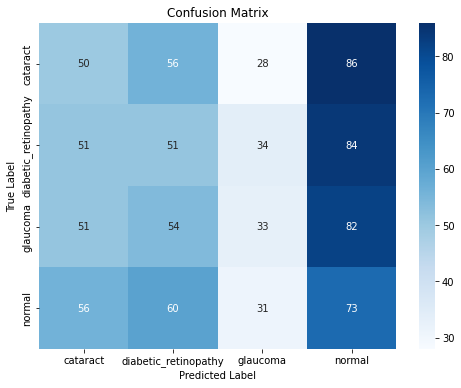

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

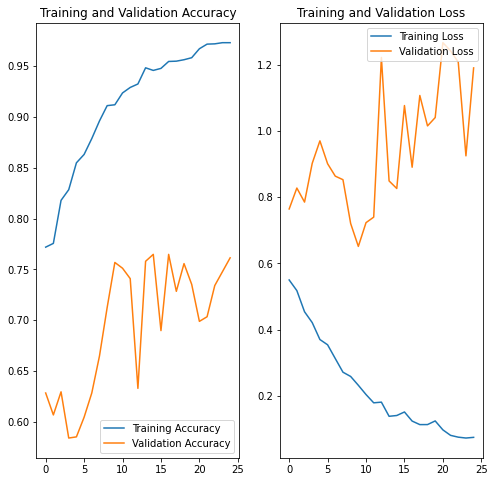

In [48]:
import matplotlib.pyplot as plt

# relevant metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the number of epochs
epochs_range = range(len(acc))  

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()